In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame

In [2]:
pd.options.display.max_rows = 10

Create a HDF Store for serializing the data

In [3]:
store = pd.HDFStore('store.h5')

# ADAC - df0 mit Abgasnorm Euro 6d-Temp, Euro 6d

[ADAC - df0 mit Abgasnorm Euro 6d-Temp, Euro 6d](https://www.adac.de/rund-ums-fahrzeug/auto-kaufen-verkaufen/neuwagenkauf/euro-6d-temp-modelle)

In [3]:
url = "https://www.adac.de/rund-ums-fahrzeug/auto-kaufen-verkaufen/neuwagenkauf/euro-6d-temp-modelle"

res = pd.read_html(url, header=0)

Concatenate all tables and reindex 

In [4]:
df0 = pd.concat((elt for elt in res), ignore_index=True)
df0.rename({
    'Markt-  einführung': 'Markteinfuehrung',
    'Hubraum in ccm': 'Hubraum',
    'Leistung in KW': 'Leistung'
    }, axis=1, inplace=True)

Convert *Markteinfuehrung* col to datetime

For date manipulation, see for ex.https://www.python-kurs.eu/python3_time_and_date.php

In [5]:
import locale

locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

pat = r"^(\w{3}).*(\d{2})$"
repl = lambda m: f"{m.group(1)} {m.group(2)}"

df0.Markteinfuehrung = df0.Markteinfuehrung \
    .str.replace('^v', 'Nov') \
    .str.replace('(Mrz|Mar)', 'Mär') \
    .str.replace(pat, repl)

df0.Markteinfuehrung = pd.to_datetime(df0.Markteinfuehrung, format='%b %y', errors='coerce')

In [25]:
df0 = df0.astype({
    'Hersteller': 'category',
    'Modell': str,
    'Motorart': 'category',
    'Abgasnorm': 'category'
    })

In [26]:
df0.dtypes

Hersteller                category
Modell                      object
Motorart                  category
Hubraum                      int64
Leistung                     int64
Abgasnorm                 category
Markteinfuehrung    datetime64[ns]
dtype: object

In [11]:
df0.sample(3)

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
2677,VW,Caddy Maxi Kombi 2.0 TDI SCR,Diesel,1968,75,Euro 6d-TEMP-EVAP,2018-10-01
690,Dacia,Dokker Blue dCi 75,Diesel,1461,55,Euro 6d-TEMP-EVAP,2018-09-01
1226,Lamborghini,Huracán LP580-2,Otto,5204,426,Euro 6d-TEMP,2018-09-01


In [28]:
df0.memory_usage()

Index                 128
Hersteller           4506
Modell              22992
Motorart             3082
Hubraum             22992
Leistung            22992
Abgasnorm            3250
Markteinfuehrung    22992
dtype: int64

Save to the store

In [40]:
store.put('ADAC', df0, format='table')

In [98]:
print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: store.h5
/ADAC                                     frame_table  (typ->appendable,nrows->2874,ncols->7,indexers->[index],dc->[])    
/ADAC/meta/values_block_0/meta            series_table (typ->appendable,nrows->44,ncols->1,indexers->[index],dc->[values])
/ADAC/meta/values_block_1/meta            series_table (typ->appendable,nrows->6,ncols->1,indexers->[index],dc->[values]) 
/ADAC/meta/values_block_2/meta            series_table (typ->appendable,nrows->7,ncols->1,indexers->[index],dc->[values]) 


In [100]:
store.get('/ADAC')

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
0,Abarth,595,Otto,1368,107,Euro 6d-TEMP-EVAP,2018-09-01
1,Abarth,595 Pista,Otto,1368,118,Euro 6d-TEMP-EVAP,2018-09-01
2,Abarth,595 Turismo,Otto,1368,121,Euro 6d-TEMP-EVAP,2018-09-01
3,Abarth,595 Competizione,Otto,1368,132,Euro 6d-TEMP-EVAP,2018-09-01
4,Abarth,595C,Otto,1368,107,Euro 6d-TEMP-EVAP,2018-09-01
...,...,...,...,...,...,...,...
2869,VW,Touran 2.0 TDI SCR,Diesel,1968,140,Euro 6d-TEMP,2019-01-01
2870,VW,up! 1.0,Otto,999,44,Euro 6d-TEMP,2018-08-01
2871,VW,up! 1.0,Otto,999,55,Euro 6d-TEMP,2018-08-01
2872,VW,up! 1.0 TSI,Otto,999,66,Euro 6d-TEMP,2018-09-01


# Umweltdaten Nürnberg

[Messstation Jakobsplatz - Stadt Nürnberg](http://umweltdaten.nuernberg.de/aussenluft/stadt-nuernberg/messstation-jakobsplatz.html)

In [33]:
def get_air_data_in_nuremberg(where: str, what: str, year: int):
    opts = {
        'skiprows': range(0, 10),
        'encoding': 'ISO-8859-1',
        'sep': ';',
        'parse_dates': [0],
        'index_col': 0,
        'na_values': ['-']
    }    
    url = (f"http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/"
                f"archiv/csv-export/SUN/{where}/{what}/"
                f"individuell/01.01.{year}/31.12.{year}/export.csv")
    return pd.read_csv(url, **opts)

In [14]:
df = pd.concat([get_air_data_in_nuremberg(where="nuernberg-jakobsplatz", what="stickstoffdioxid", year=y) for y in range(2005, 2020)])

In [ ]:
http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/messstation-jakobsplatz/feinstaub-pm10/csv-export/SUN/nuernberg-jakobsplatz/staubpartikel-pm10/7-Tages-Ansicht/export.csv

In [42]:
Nu2HD5 = {
    'nuernberg-jakobsplatz': 'JAKOBSPALTZ',
    'nuernberg-flugfeld': 'FLUGFELD',
    'stickstoffmonoxid': 'NO',
    'stickstoffdioxid': 'NO2',
    'ozon': 'O3',
    'staubpartikel-pm10': 'PM10',
    'staub-pm-25': 'PM25'
}

In [43]:
from itertools import product

for what, where in product([k for k in Nu2HD5.keys() if 'nuernberg' not in k],
                           [k for k in Nu2HD5.keys() if 'nuernberg' in k]):
    try:
        df = pd.concat([get_air_data_in_nuremberg(where=where, what=what, year=y) for y in range(2005, 2020)])

        tableName = f"AIR/{Nu2HD5[where]}/{Nu2HD5[what]}"
        store.put(tableName, df, format='table')
    except Exception as e:
        print(e)

In [44]:
print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: store.h5
/ADAC                                     frame_table  (typ->appendable,nrows->2874,ncols->7,indexers->[index],dc->[])    
/ADAC/meta/values_block_0/meta            series_table (typ->appendable,nrows->44,ncols->1,indexers->[index],dc->[values])
/ADAC/meta/values_block_1/meta            series_table (typ->appendable,nrows->6,ncols->1,indexers->[index],dc->[values]) 
/ADAC/meta/values_block_2/meta            series_table (typ->appendable,nrows->7,ncols->1,indexers->[index],dc->[values]) 
/AIR/FLUGFELD/NO                          frame_table  (typ->appendable,nrows->127817,ncols->1,indexers->[index],dc->[])  
/AIR/FLUGFELD/NO2                         frame_table  (typ->appendable,nrows->127779,ncols->1,indexers->[index],dc->[])  
/AIR/FLUGFELD/O3                          frame_table  (typ->appendable,nrows->129541,ncols->1,indexers->[index],dc->[])  
/AIR/FLUGFELD/PM10                        frame_table  (typ->appendable,nrows->13

In [45]:
df1 = store.get('/AIR/JAKOBSPALTZ/O3')

In [46]:
df1.head()

,Wert (µg/m³)
Datum/Zeit,
2005-05-24 21:00:00,59.0
2005-01-06 00:00:00,57.0
2005-01-06 01:00:00,49.0
2005-01-06 02:00:00,51.0
2005-01-06 03:00:00,34.0


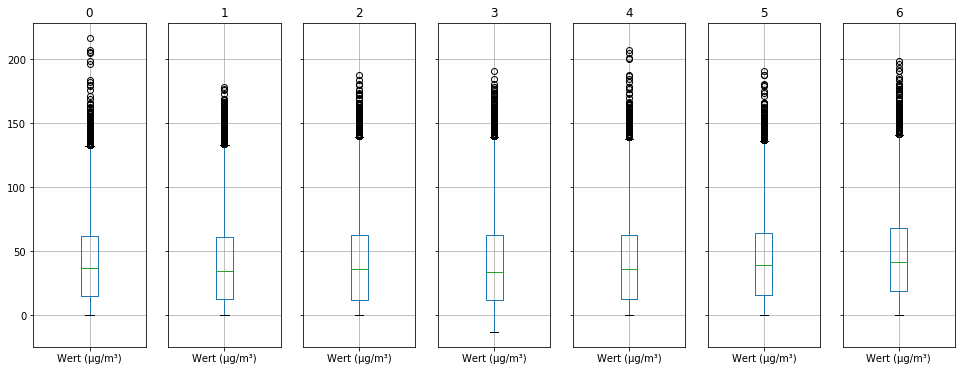

In [47]:
df1.groupby(df1.index.weekday).boxplot(layout=(1,7), figsize=(16, 6));

## with **pandas**

In [103]:
dfk = pd.read_csv(make_url(where="nuernberg-jakobsplatz", what="stickstoffdioxid", year=2019), **opts)

The data will be retrieved year for year, see no

> "*Da bei den Abfragen möglicherweise große Datenmengen entstehen, wird empfohlen maximal 12 Monate als Bezugszeitraum anzugeben und bei Bedarf mehrere Abfragen durchzuführen.*"


## with **pyarrow**

In [316]:
from pyarrow import csv
from pyarrow.csv import (ReadOptions, ParseOptions, ConvertOptions)

In [319]:
read_opts = ReadOptions(skip_rows=13, column_names=["Date", "NO2"])
parse_opts = ParseOptions(delimiter=';')
conv_opts = ConvertOptions(column_types={'NO2': pa.int32()}, null_values=["-"])
# Date are not an 
# 'Date': pa.timestamp('s'),

In [320]:
from io import (BytesIO, StringIO)

bio = BytesIO(r.content.decode(encoding='ISO-8859-1').encode())

table = csv.read_csv(bio, read_options=read_opts, parse_options=parse_opts, convert_options=conv_opts)

In [322]:
table.schema

Date: string
NO2: int32

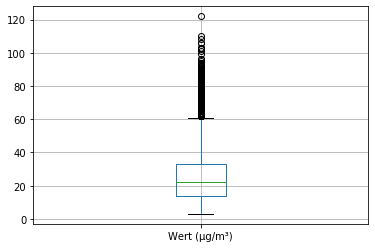

In [311]:
dfk.boxplot()

In [49]:
import pyarrow as pa

In [50]:
from pyarrow import csv

In [51]:
from requests import Session

In [55]:
year = 1

In [56]:
u1 = url.substitute(what="stickstoffdioxid",
                                 first=today.strftime('%d.%m.') + str(today.year - year - 1),
                                 until=today.strftime('%d.%m.') + str(today.year - year))

In [92]:
s = Session()

In [93]:
r = s.get(u1)

In [165]:
table.schema

Date: string
NO2: int32

In [167]:
table.to_pandas()

Date     object
NO2     float64
dtype: object

In [172]:
df1 = pd.concat((pd.read_csv(url.substitute(what="stickstoffdioxid",
                                 first=today.strftime('%d.%m.') + str(today.year - year - 1),
                                 until=today.strftime('%d.%m.') + str(today.year - year)),
                  **opts) for year in range(15)))

In [129]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112269 entries, 2019-01-01 01:00:00 to 2005-11-27 23:00:00
Data columns (total 1 columns):
Wert (µg/m³)    111358 non-null float64
dtypes: float64(1)
memory usage: 1.7 MB


In [131]:
df1['Wert (µg/m³)'].metadata = {}

In [138]:
df1['Wert (µg/m³)'].iloc[:30]

Datum/Zeit
2019-01-01 01:00:00    30.0
2019-01-01 02:00:00    29.0
2019-01-01 03:00:00    24.0
2019-01-01 04:00:00    22.0
2019-01-01 05:00:00    20.0
                       ... 
2019-02-01 02:00:00     8.0
2019-02-01 03:00:00     6.0
2019-02-01 04:00:00     7.0
2019-02-01 05:00:00     6.0
2019-02-01 06:00:00     8.0
Name: Wert (µg/m³), Length: 30, dtype: float64

In [139]:
week_df = df1.groupby(df1.index.weekday).mean()

In [142]:
df1.groupby(df1.index.weekday).describe()

Wert (µg/m³)                                                    
                  count       mean        std  min   25%   50%   75%    max
Datum/Zeit                                                                 
0               15849.0  30.795003  17.231654  1.0  18.0  27.0  40.0  133.0
1               15949.0  31.919744  17.604728  0.0  19.0  28.0  41.0  129.0
2               15943.0  32.267578  17.488338  0.0  19.0  29.0  42.0  148.0
3               15954.0  32.525385  17.798968  1.0  19.0  29.0  42.0  135.0
4               15959.0  31.770725  17.249226 -1.0  19.0  28.0  41.0  135.0
5               15816.0  28.693349  15.996195  0.0  17.0  25.0  37.0  129.0
6               15888.0  25.967082  16.686306  0.0  14.0  22.0  34.0  128.0

> "*Although fine particle OC concentrations did not correlate with day of the week, EC concentrations showed a significant weekly pattern, with the highest concentration during the middle of the workweek and the lowest concentration on Sundays.*"
https://www.ncbi.nlm.nih.gov/pubmed/15303295

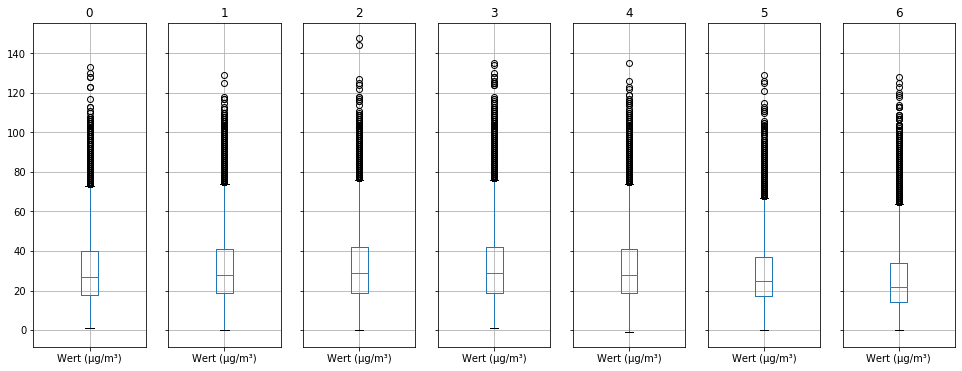

In [150]:
df1.groupby(df1.index.weekday).boxplot(layout=(1,7), figsize=(16, 6));

In [173]:
gp = df1.groupby(df1.index.weekday)

In [182]:
%timeit df1[df1.index.weekday == 2]

7.61 ms ± 75.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [183]:
%timeit df1.groupby(df1.index.weekday).get_group(2)

10.2 ms ± 73.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [184]:
df_wend = df1[df1.index.weekday == 2]

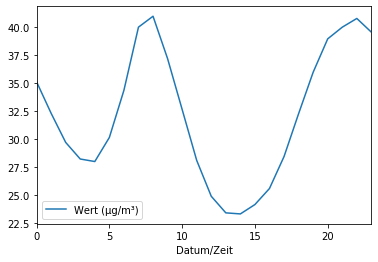

In [192]:
df_wend.groupby(df_wend.index.hour).mean().plot()

In [195]:
import seaborn as sns

In [196]:
df_wend_h = df_wend.groupby(df_wend.index.hour)

In [199]:
df_wend_h.describe()

Wert (µg/m³)                                                     
                  count       mean        std  min   25%   50%    75%    max
Datum/Zeit                                                                  
0                 667.0  35.112444  19.408852  0.0  20.0  30.0  46.00  117.0
1                 665.0  32.306767  18.458983  0.0  18.0  28.0  44.00  105.0
2                 665.0  29.712782  17.153460  0.0  16.0  25.0  40.00   94.0
3                 666.0  28.234234  15.617778  0.0  16.0  25.0  37.00   92.0
4                 667.0  28.008996  14.758310  1.0  16.0  25.0  37.00   86.0
...                 ...        ...        ...  ...   ...   ...    ...    ...
19                667.0  35.962519  18.899770  6.0  21.0  32.0  46.00  144.0
20                668.0  38.938623  19.969410  6.0  25.0  36.0  48.25  148.0
21                666.0  39.978979  20.332119  4.0  25.0  36.0  50.00  125.0
22                665.0  40.756391  20.704699  6.0  26.0  37.0  52.00  124.0
23                665.0  39.533835  20.385202  5.0  24.0  36.0  51.00  118.0

[24 rows x 8 columns]

In [ ]:
sns.pointplot(x="day", y="tip", data=tips, ci=68)

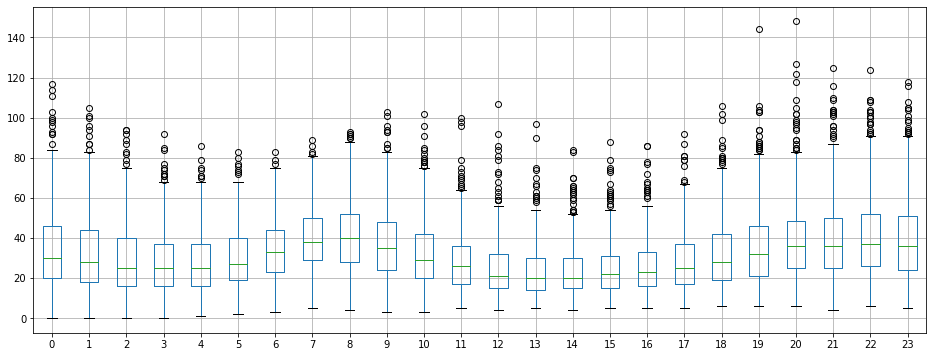

In [228]:
df_wend_h.boxplot(subplots=False, figsize=(16, 6), column=list(df_wend_h.groups.keys()))

In [205]:
df_wend_h.describe()

Wert (µg/m³)                                                     
                  count       mean        std  min   25%   50%    75%    max
Datum/Zeit                                                                  
0                 667.0  35.112444  19.408852  0.0  20.0  30.0  46.00  117.0
1                 665.0  32.306767  18.458983  0.0  18.0  28.0  44.00  105.0
2                 665.0  29.712782  17.153460  0.0  16.0  25.0  40.00   94.0
3                 666.0  28.234234  15.617778  0.0  16.0  25.0  37.00   92.0
4                 667.0  28.008996  14.758310  1.0  16.0  25.0  37.00   86.0
...                 ...        ...        ...  ...   ...   ...    ...    ...
19                667.0  35.962519  18.899770  6.0  21.0  32.0  46.00  144.0
20                668.0  38.938623  19.969410  6.0  25.0  36.0  48.25  148.0
21                666.0  39.978979  20.332119  4.0  25.0  36.0  50.00  125.0
22                665.0  40.756391  20.704699  6.0  26.0  37.0  52.00  124.0
23                665.0  39.533835  20.385202  5.0  24.0  36.0  51.00  118.0

[24 rows x 8 columns]

In [204]:
df_wend_h.boxplot(by='Datum/Zeit', figsize=(16, 10));

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f6ff8de0d90> (for post_execute):


KeyboardInterrupt: 

In [152]:
df1.describe()

,Wert (µg/m³)
count,111358.000000
mean,30.567341
std,17.305318
min,-1.000000
25%,18.000000
50%,27.000000
75%,40.000000
max,148.000000


In [163]:
np.arange(-1, 150, 20).reshape(1, 8).shape

(1, 8)

In [170]:
df1.iloc[:, 0].to_numpy()

array([30., 29., 24., ..., 38., 33., 39.])

In [172]:
cut = pd.qcut(df1.iloc[:, 0].to_numpy(), q=10)

In [174]:
df1.groupby(cut).mean()

,Wert (µg/m³)
"(-1.001, 12.0]",9.379547
"(12.0, 16.0]",14.562010
"(16.0, 19.0]",17.998225
"(19.0, 23.0]",21.479578
"(23.0, 27.0]",25.477695
"(27.0, 31.0]",29.440277
"(31.0, 37.0]",34.399984
"(37.0, 44.0]",40.804197
"(44.0, 54.0]",49.080055
"(54.0, 148.0]",67.818124


In [140]:
week_df

,Wert (µg/m³)
Datum/Zeit,
0,30.795003
1,31.919744
2,32.267578
3,32.525385
4,31.770725
5,28.693349
6,25.967082


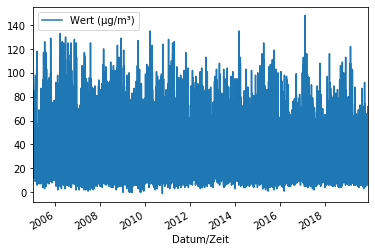

In [128]:
df1.plot()

In [ ]:
http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/archiv/csv-export/SUN/nuernberg-jakobsplatz/stickstoffmonoxid/individuell/01.06.2005/27.11.2019/export.csv
http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/archiv/csv-export/SUN/nuernberg-jakobsplatz/lufttemperatur-aussen/individuell/01.06.2005/27.11.2019/export.csv
http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/archiv/csv-export/SUN/nuernberg-jakobsplatz/stickstoffdioxid/individuell/01.06.2005/27.11.2019/export.csv    
http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/archiv/csv-export/SUN/nuernberg-jakobsplatz/staub-pm-25/individuell/01.06.2005/27.11.2019/export.csv    
http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/archiv/csv-export/SUN/nuernberg-jakobsplatz/staubpartikel-pm10/individuell/01.06.2005/27.11.2019/export.csv    

In [ ]:
http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/archiv/csv-export/SUN/nuernberg-jakobsplatz/staubpartikel-pm10/individuell/01.06.2005/27.11.2019/export.csv    

In [17]:
urls = {
    'stickstoffmonoxid': "http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/messstation-jakobsplatz/stickstoffmonoxid/csv-export/SUN/nuernberg-jakobsplatz/stickstoffmonoxid/7-Tages-Ansicht/export.csv",
    'stickstoffdioxid': "http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/messstation-jakobsplatz/stickstoffdioxid/csv-export/SUN/nuernberg-jakobsplatz/stickstoffdioxid/7-Tages-Ansicht/export.csv",
    'ozon': "http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/messstation-jakobsplatz/ozon/csv-export/SUN/nuernberg-jakobsplatz/ozon/7-Tages-Ansicht/export.csv",
    'pm10': "http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/messstation-jakobsplatz/feinstaub-pm10/csv-export/SUN/nuernberg-jakobsplatz/staubpartikel-pm10/7-Tages-Ansicht/export.csv",
    'pm25': "http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/messstation-jakobsplatz/feinstaub-pm25/csv-export/SUN/nuernberg-jakobsplatz/staub-pm-25/7-Tages-Ansicht/export.csv"
}

In [28]:
opts = {
    'skiprows': range(10),
    'encoding': 'ISO-8859-1',
    'sep': ";", 'index_col':0
}

res = {comp: pd.read_csv(url, **opts) for comp, url in urls.items()}

In [ ]:
http://umweltdaten.nuernberg.de/csv/aussenluft/stadt-nuernberg/archiv/csv-export/SUN/nuernberg-jakobsplatz/stickstoffdioxid/individuell/01.06.2005/27.11.2019/export.csv    

In [29]:
[df.shape for df in res.values()]

[(187, 1), (187, 1), (187, 1), (187, 1), (187, 1)]

In [30]:
res['ozon']

,Wert (µg/m³)
Datum/Zeit,
20.11.2019 01:00,23
20.11.2019 02:00,31
20.11.2019 03:00,32
20.11.2019 04:00,25
20.11.2019 05:00,27
...,...
27.11.2019 15:00,12
27.11.2019 16:00,8
27.11.2019 17:00,6


In [18]:
import stumpy

In [37]:
val = dfk.dropna().to_numpy().ravel()

In [39]:
st = stumpy.stump(val, val.size // 330)

In [32]:
import matplotlib.pyplot as plt

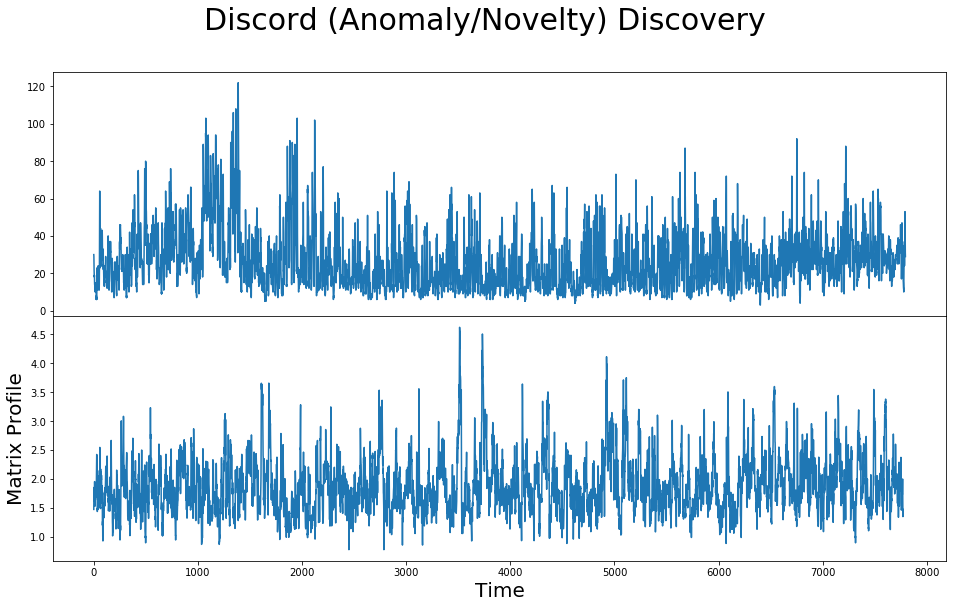

In [40]:
fig, axs = plt.subplots(2, sharex=True, 
                        figsize=(16,9),
                        gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='30')

axs[0].plot(val)

axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
#axs[1].axvline(x=3864, linestyle="dashed")
axs[1].plot(st[:, 0])